In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
import numpy as np

2024-11-04 15:32:34.013870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 15:32:34.028125: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 15:32:34.032410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1730734361.595120   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734361.618804   10821 cuda_executor.cc:1015] succ

## learnMSA demo

In this notebook, we will fit a number of HMM models to a dataset of unaligned sequences. 
We will then use the fitted models to align the sequences and compare the results.
Moreover, we will visualize the best (according to an objective criterion) model and alignment.

*This notebook is meant to be a demo for running learnMSA in Python code. Check the readme if you want to run learnMSA from the command line.* 

Change the variables in the following cell to fit your needs.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 10

# Use sequence weights based on a rapid pre-clustering of the sequences (requires mmseqs2 to be installed)
use_weights = True

# Align long insertions with an external aligner left unaligned by the main MSA stage (requires famsa to be installed).
align_insertions = True

## Run learnMSA from Python (Training + Viterbi alignment)

Training of 10 models on file egf.fasta
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=100

I0000 00:00:1730734378.965268   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734378.965554   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734378.965756   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734378.966002   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1730734383.228847   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734383.229140   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734383.229335   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734383.229571   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

34/34 - 41s - 1s/step - loss: 97.3451 - loglik: -8.3765e+01 - prior: -1.3580e+01 - aux_loss: 0.0000e+00
Epoch 2/10
34/34 - 4s - 123ms/step - loss: 70.8702 - loglik: -6.8303e+01 - prior: -2.5671e+00 - aux_loss: 0.0000e+00
Epoch 3/10
34/34 - 4s - 123ms/step - loss: 69.1054 - loglik: -6.7172e+01 - prior: -1.9331e+00 - aux_loss: 0.0000e+00
Epoch 4/10
34/34 - 4s - 121ms/step - loss: 68.9455 - loglik: -6.7164e+01 - prior: -1.7812e+00 - aux_loss: 0.0000e+00
Epoch 5/10
34/34 - 4s - 120ms/step - loss: 68.6550 - loglik: -6.6914e+01 - prior: -1.7408e+00 - aux_loss: 0.0000e+00
Epoch 6/10
34/34 - 4s - 122ms/step - loss: 68.6028 - loglik: -6.6895e+01 - prior: -1.7076e+00 - aux_loss: 0.0000e+00
Epoch 7/10
34/34 - 4s - 122ms/step - loss: 68.6050 - loglik: -6.6928e+01 - prior: -1.6766e+00 - aux_loss: 0.0000e+00
Fitted model successfully.
Creating alignment model...
Successfully created alignment model.


I0000 00:00:1730734452.282021   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734452.282341   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734452.282562   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734452.282849   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: [(12, 9), (13, 1)]
discards model 0: []
expansions model 1: [(10, 1), (13, 3), (14, 1), (17, 1), (19, 2)]
discards model 1: []
expansions model 2: [(12, 2), (13, 2), (15, 1)]
discards model 2: []
expansions model 3: [(12, 2), (13, 3), (14, 1), (17, 1), (19, 2)]
discards model 3: []
expansions model 4: [(12, 7), (15, 1), (17, 2)]
discards model 4: []
expansions model 5: [(12, 4), (13, 2), (16, 1), (18, 2)]
discards model 5: []
expansions model 6: [(12, 2), (14, 2), (15, 1)]
discards model 6: []
expansions model 7: [(12, 7), (15, 1), (17, 2)]
discards model 7: []
expansions model 8: [(10, 1), (11, 2), (12, 3), (13, 1), (16, 1), (18, 2)]
discards model 8: []
expansions model 9: [(12, 2), (13, 3), (16, 1), (17, 1)]
discards model 9: []
Re-initialized the encoder parameters.
Fitting models of lengths [32, 33, 33, 34, 33, 33, 33, 33, 34, 33] on 7774 sequences.
Batch size= 256 Learning rate= 0.1
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.027

I0000 00:00:1730734460.586385   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734460.586691   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734460.586881   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734460.587111   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1730734464.189588   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734464.189905   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734464.190126   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734464.190394   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

34/34 - 38s - 1s/step - loss: 76.1030 - loglik: -6.3758e+01 - prior: -1.2345e+01 - aux_loss: 0.0000e+00
Epoch 2/10
34/34 - 4s - 119ms/step - loss: 65.2398 - loglik: -6.3210e+01 - prior: -2.0298e+00 - aux_loss: 0.0000e+00
Epoch 3/10
34/34 - 4s - 120ms/step - loss: 64.6691 - loglik: -6.3390e+01 - prior: -1.2793e+00 - aux_loss: 0.0000e+00
Epoch 4/10
34/34 - 4s - 120ms/step - loss: 64.4275 - loglik: -6.3318e+01 - prior: -1.1099e+00 - aux_loss: 0.0000e+00
Epoch 5/10
34/34 - 4s - 120ms/step - loss: 64.2471 - loglik: -6.3222e+01 - prior: -1.0255e+00 - aux_loss: 0.0000e+00
Epoch 6/10
34/34 - 4s - 120ms/step - loss: 64.1769 - loglik: -6.3234e+01 - prior: -9.4273e-01 - aux_loss: 0.0000e+00
Epoch 7/10
34/34 - 4s - 119ms/step - loss: 64.1683 - loglik: -6.3287e+01 - prior: -8.8091e-01 - aux_loss: 0.0000e+00
Epoch 8/10
34/34 - 4s - 118ms/step - loss: 63.9633 - loglik: -6.3142e+01 - prior: -8.2108e-01 - aux_loss: 0.0000e+00
Epoch 9/10
34/34 - 4s - 118ms/step - loss: 63.9210 - loglik: -6.3138e+01 - pr

I0000 00:00:1730734543.858815   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734543.859106   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734543.859299   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734543.859532   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

too many seqs for Viterbi rerun
Aligning 2 insertion slices with famsa.


/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


time for generating output: 3.4124
Wrote file test/data/interactive.alignment.fasta
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 185ms/step
>l=-54.83_t=0.00
............$C....D.......P......N............P........CYN.HG..T..C....S......................L......RA...T...-.......G........YTCSCL....PR......Y....T...GEH$.......................
>l=-57.18_t=0.00
............$C....D.......S......Q............P........CRN.-G..T..C....S......................L......NT...N...T.......D........YTCACF....PG......Y....T...GRY$.......................
>l=-50.27_t=0.00
............$C....D.......S......D............P........CLN.GG..T..C....T......................Lr.....SL...D...-.......S........YSCACA....PG......Y....T...GQH$.......................
>l=-62.25_t=0.00
............$C....D.......H......V............T........CLN.GG..T..C....Q......................Lk.....TL...E...-.......D........YTCACA....NG......Y....T...GER$.......................
>l=-62.67_t=0.00
............$C....D.......H......V............T........CLN.GG.

/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1730734556.650264   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734556.650661   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730734556.650961   10821 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but 

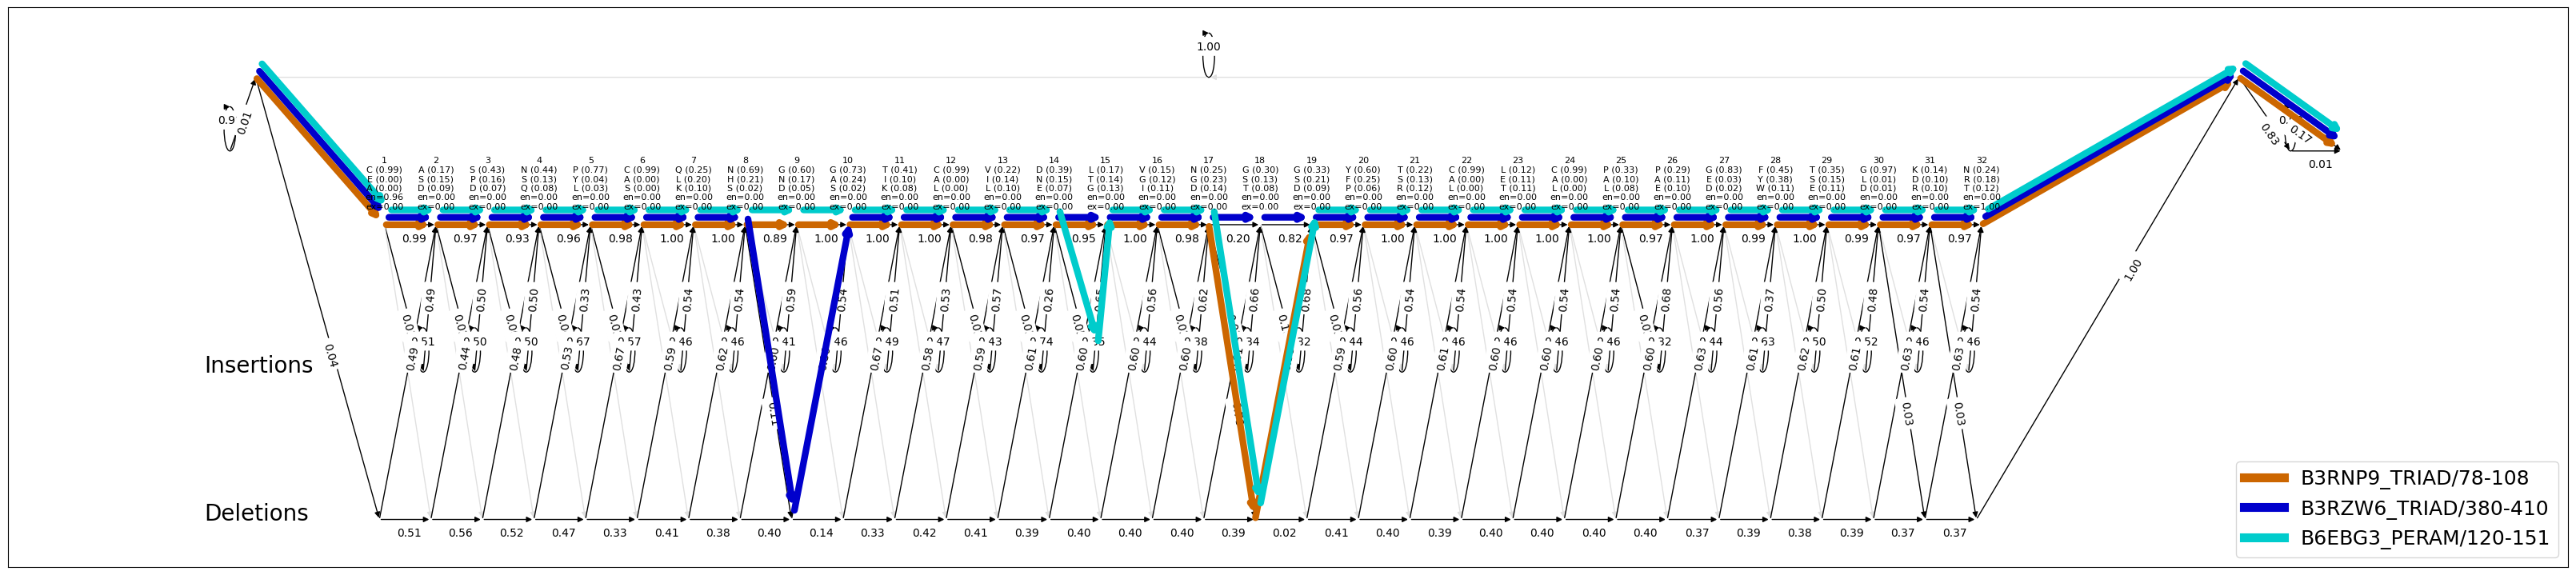

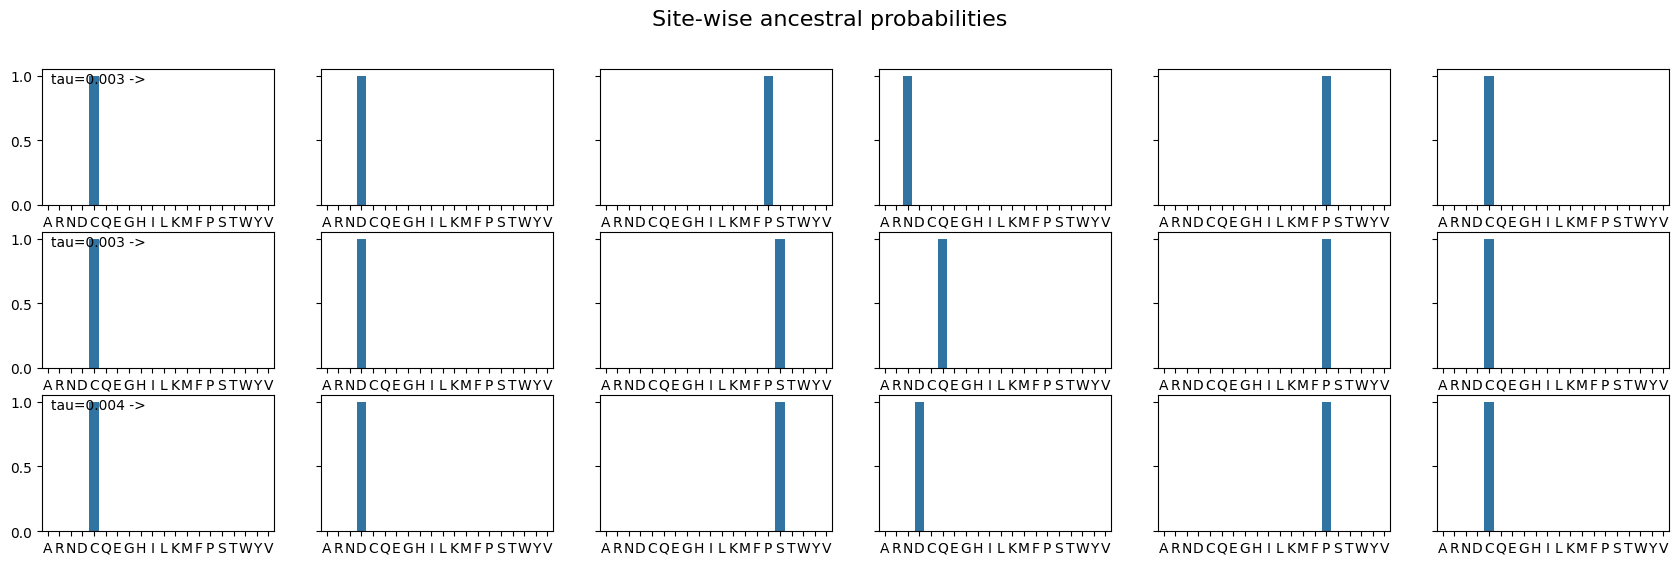

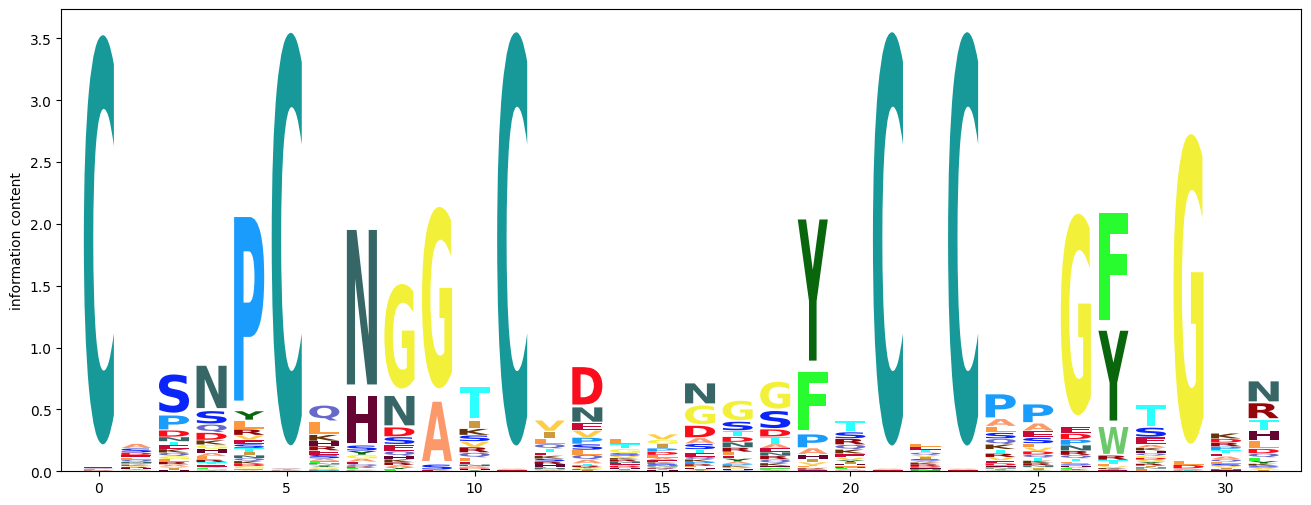

In [3]:
out_filename = "test/data/interactive.alignment.fasta"
config = Configuration.make_default(num_models)
with SequenceDataset(train_filename, fmt="fasta") as data:
    config["crop_long_seqs"] = int(np.ceil(2 * np.mean(data.seq_lens))) #comment out to disable cropping
    config["max_surgery_runs"] = 2
    alignment_model = Align.run_learnMSA(data,
                                        out_filename,
                                        config, 
                                        sequence_weights=Align.compute_sequence_weights(train_filename, "tmp") if use_weights else None,
                                        verbose=True,
                                        align_insertions=align_insertions)
    Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [4]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1ixa
HERE: 1apo
HERE: 1urk
HERE: 1fsb
HERE: 1esl
HERE: 1hre
HERE: 1epi
HERE: 4tgf
HERE: 1hcgb
HERE: 1dan1
HERE: 1dan2
HERE: 1rfnb


In [5]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
egf           12         31.1    79.5 [100.0]   [ 5182]
